C:\Users\whrow\AppData\Local\Temp\ipykernel_21364\3292485773.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.wind = torch.tensor(wind)


Your vector field does not have `nn.Parameters` to optimize.


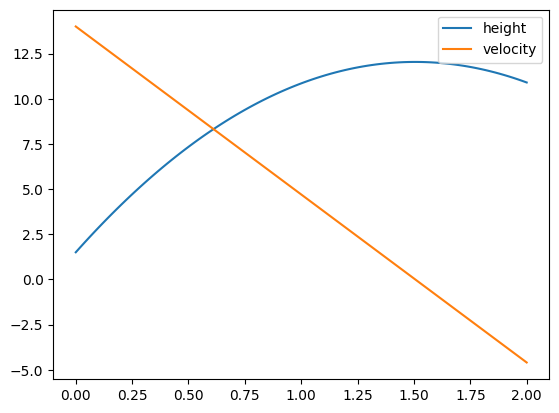

In [43]:
import torch
import torch.nn as nn
from torchdyn.models import NeuralODE
import pytorch_lightning as pl
from torchdiffeq import odeint
import matplotlib.pyplot as plt


### FINN 적용

In [ ]:

class NeuralODEBallThrowing(nn.Module):
    def __init__(self, wind):
        super().__init__()
        ## 바람은 텐서 형식으로
        self.wind = torch.tensor(wind)

    def forward(self, t, y):
        g = torch.tensor(9.8).to(self.wind.device)
        dhdt = y[:, 1]
        dvdt = -g + self.wind
        return torch.cat((dhdt.view(-1, 1), dvdt.view(-1, 1)), dim=1)
    
    


### 공 던지기 학습 데이터 세팅

In [ ]:
data = []

for h0 in torch.linspace(1.0, 2.0, 10):  # 초기 높이
    for v0 in torch.linspace(10.0, 20.0, 10):  # 초기 속도
        for wind in torch.linspace(0.0, 1.0, 10):  # 바람 세기
            func = NeuralODEBallThrowing(wind=wind)
            y0 = torch.tensor([[h0, v0]])
            trajectory = odeint(func, y0, t_span)
            data.append((h0, v0, wind, trajectory))


### 모델 학습(간략한 모델)

In [ ]:

class Learner(pl.LightningModule):
    def __init__(self, t_span:torch.Tensor, model:nn.Module):
        super().__init__()
        self.model, self.t_span = model, t_span
    
    def forward(self, x):
        h0, v0, wind = x
        self.model.wind = wind
        y0 = torch.tensor([[h0, v0]])
        return odeint(self.model, y0, self.t_span)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        # train_data는 앞서 생성한 데이터셋을 사용
        train_data = [(torch.tensor([h0, v0, wind]), trajectory) for h0, v0, wind, trajectory in data]
        return torch.utils.data.DataLoader(train_data, batch_size=32)



### 변수(바람) 초기조건 추가

In [ ]:


# 바람의 세기
wind = 0.5
func = NeuralODEBallThrowing(wind=wind)
neural_ode = NeuralODE(func)

# 초기 조건 및 시간
h0 = 1.5  # initial height
v0 = 14.  # initial velocity
t_span = torch.linspace(0, 2, 100)
y0 = torch.tensor([[h0, v0]])

# 시뮬레이션
solution = odeint(func, y0, t_span)



# 결과 그리기
plt.plot(t_span.detach(), solution[:, 0, 0].detach(), label='height')
plt.plot(t_span.detach(), solution[:, 0, 1].detach(), label='velocity')
plt.legend()
plt.show()

